# Exploring the securitites performance data
The dataset is taken from https://www.kaggle.com/c/two-sigma-financial-modeling, which was hosted as part of one of their machine learning competition.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', 120)

In [4]:
with pd.HDFStore("train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")

In [5]:
print("Train data shape: {}".format(df.shape))
df.head()

Train data shape: (1710756, 111)


,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,NaN,-0.072108,0.249187,0.024401,-0.127942,NaN,1.412742,-0.029575,1.265246,-0.055747,1.592256,-0.285275,-0.212888,0.404180,0.116903,0.197590,-0.197455,-0.195023,-0.059886,-0.021199,-0.013555,-0.236371,-0.253357,0.575562,0.283947,-0.006208,0.616351,-0.034578,0.732652,-0.002432,-0.092508,-0.072185,0.447296,-0.194318,0.264373,0.018763,NaN,-0.145278,-0.108547,0.148189,-0.226942,0.262864,-0.252933,-0.113265,0.180559,-0.033812,0.042951,-0.068031,0.208402,-0.082743,1.061059,1.120801,-0.228200,-0.119987,-0.131929,-0.145985,-0.155989,NaN,0.037680,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.273957,NaN,-2.0,-2.0,NaN,0.001652,-2.0,NaN,-2.0,NaN,0.652981,0.000000,-0.142453,0.0,NaN,NaN,1.427469,NaN,-2.0,0.0,NaN,NaN,NaN,0.0,0.937880,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.09675,0.082042,-0.224383,-0.085529,0.024763,-0.062337,-0.202247,1.746692,-0.187505,-0.034664,-0.135177,0.305562,0.027595,-0.208746,0.118520,-0.123511,0.113818,NaN,-0.115837,0.028282,0.076565,-0.217346,0.100054,0.358808,0.057505,0.025719,-0.141339,2.293476,0.024945,0.388208,-0.240927,-0.126232,-0.131619,0.232268,-0.001455,-0.489863,0.017317,0.027321,0.334183,0.113513,0.111536,-0.179379,0.221287,-0.091886,NaN,0.107982,0.548687,-0.160079,-0.281368,0.063933,-0.235643,-0.205083,-0.194349,-0.365186,0.041928,-0.044907,-0.039079,-0.075000,-0.280418,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.159432,NaN,0.0,-2.0,NaN,0.004317,0.0,NaN,-2.0,NaN,-0.399520,0.000000,-0.309356,-0.5,NaN,NaN,0.154613,NaN,0.0,0.0,NaN,NaN,NaN,0.5,0.232154,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,NaN,NaN,-0.051418,-0.258330,-0.122140,-0.121041,-0.058287,-0.899515,-0.022131,-0.079002,-0.031116,-0.100603,-0.341474,-0.007522,0.077977,-0.149581,0.036946,0.166182,NaN,0.172751,0.961091,1.028205,-0.165369,0.056006,NaN,0.249530,-0.156078,NaN,0.019192,0.053364,-0.020247,NaN,0.064028,-0.249106,-0.106216,-0.085509,0.383589,NaN,-0.074021,-0.054295,-0.746073,-0.057605,-0.126238,0.462523,0.060902,NaN,-0.262892,-0.059395,0.562975,-0.026392,0.013430,-0.627150,-0.470362,-0.101865,0.436794,-0.057049,-0.120851,-0.061941,-0.600019,0.138357,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.227811,NaN,-2.0,-2.0,NaN,0.000000,-2.0,NaN,-2.0,NaN,-0.496284,0.006942,0.122841,-0.5,NaN,NaN,0.378332,NaN,-2.0,

Looking at the above dataset and having read the data description at Kaggle, We can see that the 'id' represents the unique identity of different securitites. And the rest of the columns till the second last column represent different technical and funademtal parameters of the underlying security.The last column 'y' represents the return of the asset in that particular time period. And the dataset is arranged in the ascending order of time (time series).

We have series of data of 1710756 (number of rows) securities and 109 features that determine the 'y' value.

The security id's and the features(columns) are kept anonymous and that makes the analysis more interesting and challeging at the same time.

In this noteboook we'll be doing an analysis that will serve as a preprocessing and feature engineering step for designing a predictive model.
The steps would be as follows.
------------------------------------------------
1)Identify the number of different securities in the universe and do a basic analysis of data

2)Studying the correlation/affect of the features on the return on the secuirty.
    ->Finding the linear correlation  and spearman correlation between the features and the returns.
    ->Finding the important features using XGBOOST
    
3)Digging further the top features found out above and analysing their predictive power.

4)Doing a K-means clustering to further differentiate the assets into different category- this will serve as a crucial step in building models. Eg: Stocks and bonds have different characterstics and their features will be disparate. So using the stock and bond data as training set for a model would be like comparing meat to vegetables.


## 1) Basic Analysis

In [6]:
len(df.id.unique()) # how many assets (instruments) are we tracking?

1424

In [7]:
len(df.timestamp.unique()) # how many periods?

1813

#### Visualizing  the returns

In [8]:
market_df = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
market_df.head()

timestamp         y                 
                 mean       std    len
0         0 -0.001870  0.026646  750.0
1         1  0.000501  0.028422  750.0
2         2 -0.005787  0.029281  750.0
3         3  0.001633  0.025333  750.0
4         4 -0.004309  0.035929  750.0

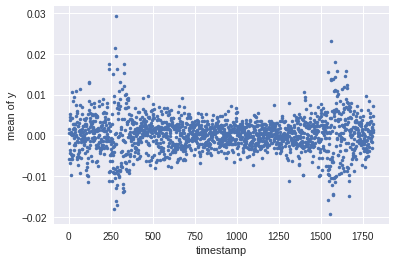

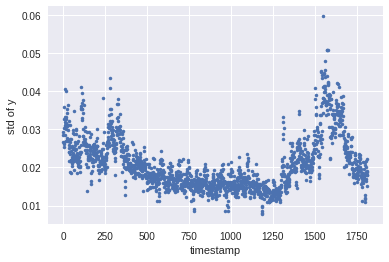

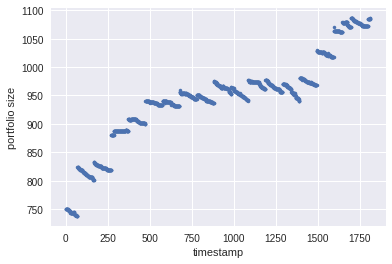

In [9]:
t      = market_df['timestamp']
y_mean = np.array(market_df['y']['mean'])
y_std  = np.array(market_df['y']['std'])
n      = np.array(market_df['y']['len'])

plt.figure()
plt.plot(t, y_mean, '.')
plt.xlabel('timestamp')
plt.ylabel('mean of y')

plt.figure()
plt.plot(t, y_std, '.')
plt.xlabel('timestamp')
plt.ylabel('std of y')

plt.figure()
plt.plot(t, n, '.')
plt.xlabel('timestamp')
plt.ylabel('portfolio size')

Looking at the last chart we can see that the number of assets being tracked increases from 750 to 1100. Which means that we have a universe which is time varying.
Let's also plot the portfolio value eventhough it might not be that useful. Just to see a bigger pcture of the portfolio.

portfolio mean periodic return: 0.183126
portfolio std dev of periodic returns: 0.0922067


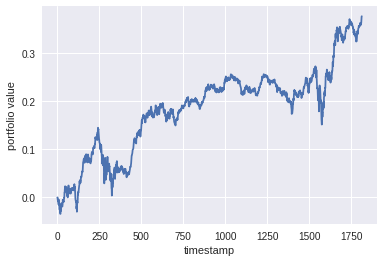

In [10]:
simple_ret = y_mean # this is a vector of the mean of asset returns for each timestamp
cum_ret = np.log(1+simple_ret).cumsum()
portfolio_mean = np.mean(cum_ret)
portfolio_std = np.std(cum_ret)
print("portfolio mean periodic return: " + str(portfolio_mean))
print("portfolio std dev of periodic returns: " + str(portfolio_std))
plt.figure()
plt.plot(t, cum_ret)
plt.xlabel('timestamp')
plt.ylabel('portfolio value')

## 2) Correlation Analysis

In [13]:
corr = df.iloc[:,2:-1].corrwith(df.y)
print('max_correlation', corr.max().max())
print('min_correlation', corr.min().min())

max_correlation 0.014271598606
min_correlation -0.0165342543096


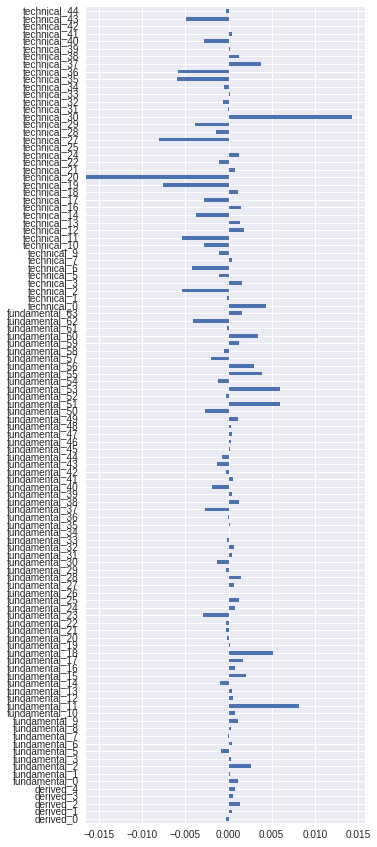

In [14]:
plt.figure(figsize=(5,15))
corr.plot(kind='barh')

None of the features have a strong linear correlation with y (We checked for pearson correlation here). Spearman correation takes a lot of processing time and thus we will limit it to features which have less than 0.5% missing values in the dataset.

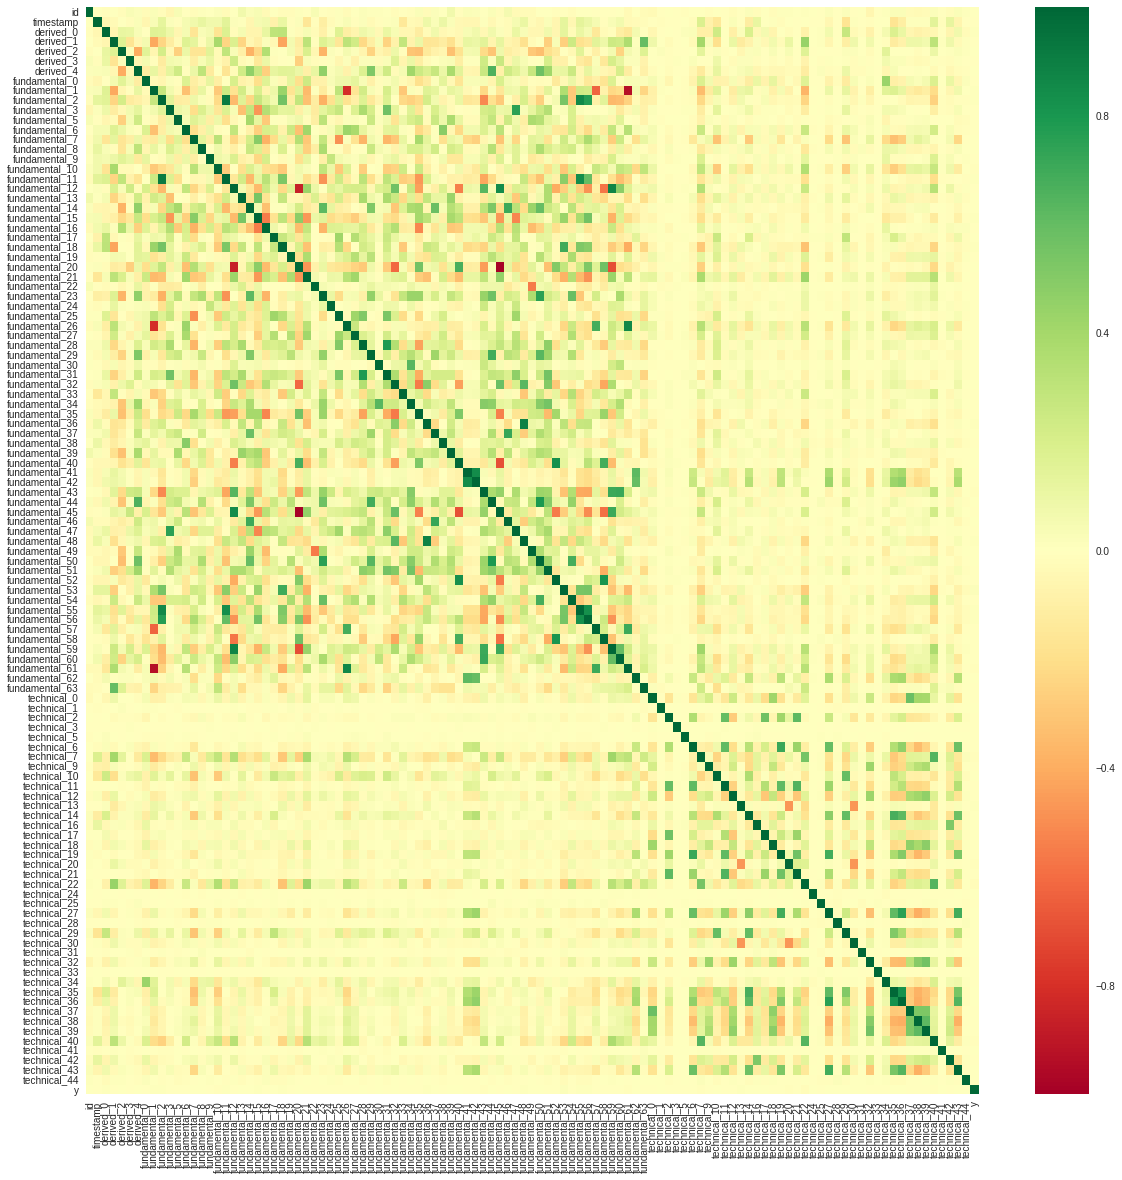

In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df_clean=df.dropna(axis='index',how='any')
df_clean.shape
df_clean.shape[0]/df.shape[0]*100
plt.figure(figsize=(20,20))
sns.heatmap(df_clean.corr(method='spearman', min_periods=1),cmap='RdYlGn')

In [ ]:
df.head()

Some observation points:
1)Features under the tag of "fundamental" have some kind of correlation among them as you can see from the box in top left quadrant of the heatmap.
2)Similarly, "technical" features are somewhat related to each other (bottom right quadrant).
3)A relatively lower correlation is seen between the two types of features. (Not a lot of greens and reds in the top right and bottom left quadrant of the heatmap).
Some of the features have close correlation to their neighbors as can be seen from green clusters on the diagnol.

### 3) Finding features with predictive power using XGBoost

In [16]:
low_y_cut = -0.086092
high_y_cut = 0.093496

print("Preparing data for model...")
df = df.sample(frac=0.1)
df.fillna(df.mean(axis=0), inplace=True)
y_is_within_cut = ((df['y'] > low_y_cut) & (df['y'] < high_y_cut))

train_X = df.loc[y_is_within_cut, df.columns[2:-1]]
train_y = df.loc[y_is_within_cut, 'y'].values.reshape(-1, 1)
print("Data for model: X={}, y={}".format(train_X.shape, train_y.shape))

Preparing data for model...
Data for model: X=(168821, 108), y=(168821, 1)


In [17]:
import xgboost as xgb
model = xgb.XGBRegressor()
print("Fitting...")
model.fit(train_X, train_y)
print("Fitting done")

Fitting...
Fitting done


Features importance done


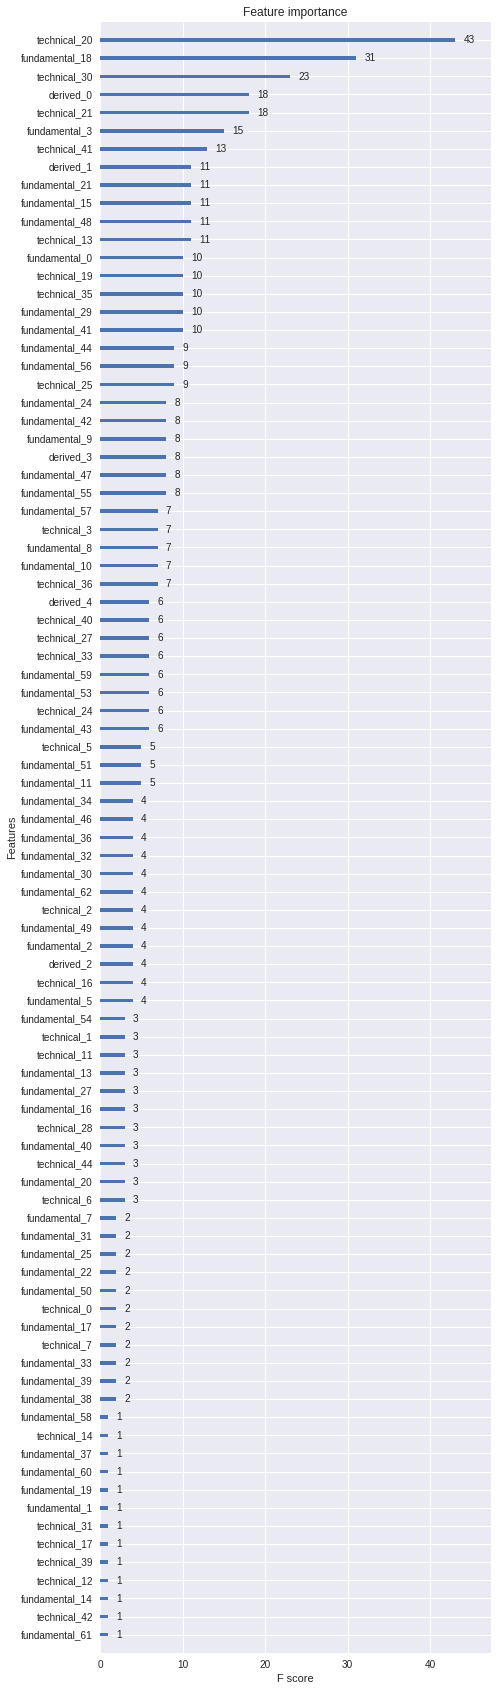

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 30))
xgb.plot_importance(model, ax=ax)
print("Features importance done")